# Explore here

In [80]:
import pandas as pd
import os
import re
import numpy as np
from nltk.corpus import stopwords
import nltk
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from urllib.parse import urlparse, urlunsplit, urlunparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import joblib


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")
# We specify a path to save the csv file.
save_path = r"D:\01A-TRABAJO\PYTHON\DATASCIENCE\EJERCICIOS\NLP\NLP\data\raw\playstore_reviews.csv" 

# We save the csv file
df.to_csv(save_path, index=False)

In [3]:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
df.shape

(2999, 2)

In [5]:
df.duplicated().sum()

np.int64(630)

In [6]:
df.drop_duplicates(inplace=True, ignore_index = True)

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df['is_spam'] = df['is_spam'].astype(int)

In [9]:
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


In [10]:
df.is_spam.value_counts()

is_spam
0    2125
1     244
Name: count, dtype: int64

We have an imbalanced dataframe, we will test by reducing the number of is_spam urls to the same number of not spam urls and compare the results.

In [11]:
frecuencia_minima = df['is_spam'].value_counts().min()

# Crear una muestra ponderada según la frecuencia de la clase minoritaria
df_adjusted = df.groupby('is_spam').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)
df_adjusted.head()

C:\Users\Prueba1\AppData\Local\Temp\ipykernel_32032\3281356034.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adjusted = df.groupby('is_spam').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)


,url,is_spam
0,https://www.wallpaper.com/art/in-memoriam-milt...,0
1,https://www.reddit.com/r/aww/comments/hiz3bh/s...,0
2,https://blog.google/products/admanager/display...,0
3,https://cheddar.com/newsletter/441ba1d8c1/share,0
4,https://www.tiktok.com/@fishesgetstitches,0


We will now make a filtering process to remove the unnecessary data from our urls, and we will then transform it into a function to loop over the url column data.

After that, we will compare the results when using df_adjusted and df, to analyse if it will be worth reducing the data to improve the model's ability to detect spam urls.

In [12]:
nltk.download('stopwords', quiet=True)

# Get English stopwords
stop_words = set(stopwords.words('english'))

# We add URL-specific stopwords
url_stop_words = {'www', 'http', 'https', 'com', 'org', 'net', 'edu', 'gov', 'co', 'io',
                  'index', 'home', 'page', 'view', 'article', 'post', 'category', 
                  'manage', 'account', 'unsubscribe', 'subscribe', 'login', 'logout', 
                  'signin', 'signout', 'register','es','html'}

# Combine general stopwords with URL-specific stopwords
all_stop_words = stop_words.union(url_stop_words)

def clean_urls(url):
    parsed = urlparse(url)
    
    # Extract domain
    domain = re.sub(r'^www\.', '', parsed.netloc)
    
    # Split domain and path
    all_parts = domain.split('.') + parsed.path.split('/')
    
    # Process words
    cleaned_words = []
    for part in all_parts:
        # Split on non-alphanumeric characters
        words = re.findall(r'\b[a-zA-Z0-9]+\b', part.lower())
        for word in words:
            if word not in all_stop_words and len(word) > 2:
                if word.startswith('sub') and 'stack' in word:
                    cleaned_words.append('substack')
                elif not word.isdigit():
                    cleaned_words.append(word)
    
    return ' '.join(cleaned_words)

In [13]:
# We test the function to make sure it works properly
url = df['url'].iloc[0]
print("Original URL:", url)
print("Cleaned URL:", clean_urls(url))

Original URL: https://briefingday.us8.list-manage.com/unsubscribe
Cleaned URL: briefingday us8 list


In [14]:
# Apply the function to the entire 'url' column
df['clean_url'] = df['url'].apply(clean_urls)

In [15]:
# Apply the function to the entire 'url' column
df_adjusted['clean_url'] = df_adjusted['url'].apply(clean_urls)

In [16]:
df.head()


,url,is_spam,clean_url
0,https://briefingday.us8.list-manage.com/unsubs...,1,briefingday us8 list
1,https://www.hvper.com/,1,hvper
2,https://briefingday.com/m/v4n3i4f3,1,briefingday v4n3i4f3
3,https://briefingday.com/n/20200618/m#commentform,0,briefingday
4,https://briefingday.com/fan,1,briefingday fan


In [17]:
df_adjusted.head()

,url,is_spam,clean_url
0,https://www.wallpaper.com/art/in-memoriam-milt...,0,wallpaper art memoriam milton glaser obituary
1,https://www.reddit.com/r/aww/comments/hiz3bh/s...,0,reddit aww comments hiz3bh
2,https://blog.google/products/admanager/display...,0,blog google products admanager display buying ...
3,https://cheddar.com/newsletter/441ba1d8c1/share,0,cheddar newsletter 441ba1d8c1 share
4,https://www.tiktok.com/@fishesgetstitches,0,tiktok fishesgetstitches


In [18]:
df_adjusted.is_spam.value_counts()

is_spam
0    244
1    244
Name: count, dtype: int64

In [19]:
df_adjusted.isna().sum()

url          0
is_spam      0
clean_url    0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   url        2369 non-null   object
 1   is_spam    2369 non-null   int64 
 2   clean_url  2369 non-null   object
dtypes: int64(1), object(2)
memory usage: 55.7+ KB


In [21]:
def generate_url_wordcloud(df, url_column='clean_url', max_words=100):
    def extract_words(url):
        parsed = urlparse(url)
        all_parts = parsed.path + ' ' + parsed.query
        words = re.findall(r'\w+', all_parts.lower())
        return ' '.join(words)

    all_words = ' '.join(df[url_column].apply(extract_words))

    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          max_words=max_words).generate(all_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of URL Components')
    plt.show()

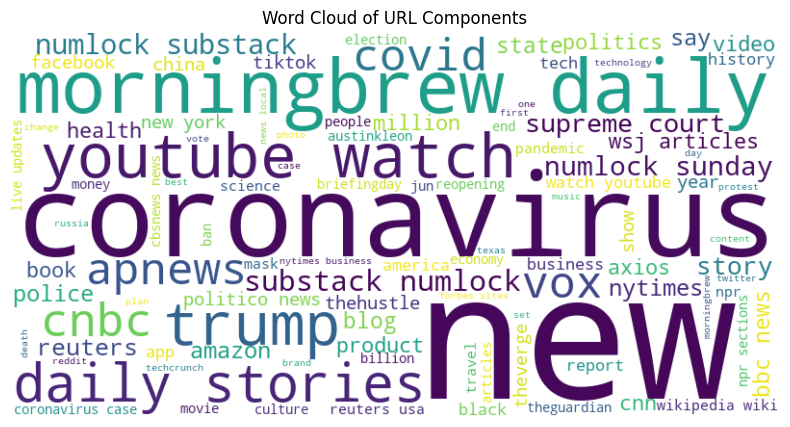

In [22]:
generate_url_wordcloud(df)

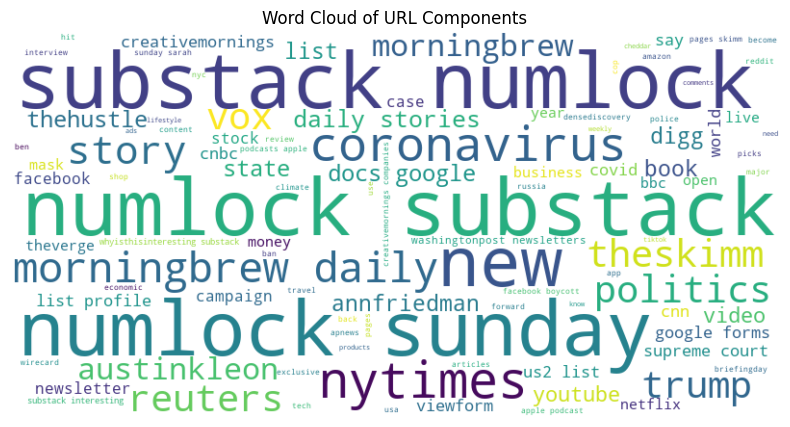

In [23]:
generate_url_wordcloud(df_adjusted)

We will now continue by converting the cleaned URL text into numerical features using the TF-IDF technique.


In [26]:
all_words = set(' '.join(df['clean_url']).split())

In [27]:
word_correlations = {}
for word in tqdm(all_words):
    correlation = df['clean_url'].str.contains(word).corr(df['is_spam'])
    word_correlations[word] = correlation

100%|██████████| 5780/5780 [00:06<00:00, 880.52it/s]


In [28]:
correlations_df = pd.DataFrame.from_dict(word_correlations, orient='index', columns=['correlation'])
correlations_df = correlations_df.sort_values('correlation', ascending=False)

In [29]:
all_words_adjusted = set(' '.join(df_adjusted['clean_url']).split())

In [30]:
word_correlations_adjusted = {}
for word in tqdm(all_words_adjusted):
    correlation_adjusted = df_adjusted['clean_url'].str.contains(word).corr(df_adjusted['is_spam'])
    word_correlations_adjusted[word] = correlation_adjusted

100%|██████████| 1508/1508 [00:00<00:00, 1949.64it/s]


In [31]:
correlations_df_adjusted = pd.DataFrame.from_dict(word_correlations_adjusted, orient='index', columns=['correlation'])
correlations_df_adjusted = correlations_df_adjusted.sort_values('correlation', ascending=False)

In [32]:
print("(Full DF) Words associated with spam:")
print(correlations_df.head(20))

print("(Adjusted DF) Words associated with spam:")
print(correlations_df_adjusted.head(20))

(Full DF) Words associated with spam:
                      correlation
numlock                  0.400477
substack                 0.390877
stack                    0.388408
sunday                   0.361916
sun                      0.320429
day                      0.209548
friedman                 0.201562
us2                      0.192141
list                     0.183797
annfriedman              0.171784
docs                     0.151883
austinkleon              0.150877
viewform                 0.147845
kim                      0.138834
skimm                    0.137466
profile                  0.137094
whyisthisinteresting     0.137094
us1                      0.135721
newsletter               0.130930
creativemornings         0.130525
(Adjusted DF) Words associated with spam:
                      correlation
substack                 0.352738
numlock                  0.314800
sunday                   0.284784
day                      0.249610
list                     0.182483
ki

In [33]:
print("(Full DF) Words associated with no-spam:")
print(correlations_df.tail(20).sort_values('correlation'))

print("(Adjusted DF) Words associated with no-spam:")
print(correlations_df_adjusted.tail(20).sort_values('correlation'))

(Full DF) Words associated with no-spam:
             correlation
new            -0.108815
news           -0.097307
art            -0.089659
story          -0.078273
ron            -0.077921
virus          -0.075858
men            -0.074841
time           -0.073402
corona         -0.071977
coronavirus    -0.071255
times          -0.069322
trump          -0.066163
nyt            -0.065035
nytimes        -0.064634
watch          -0.064634
nbc            -0.064164
tim            -0.063741
mar            -0.063008
face           -0.057364
reuters        -0.056916
(Adjusted DF) Words associated with no-spam:
          correlation
art         -0.195698
story       -0.184115
new         -0.177300
news        -0.170455
time        -0.167632
nytimes     -0.154336
face        -0.151858
trump       -0.144639
reuters     -0.144639
politics    -0.144639
facebook    -0.137073
side        -0.137073
ted         -0.132314
state       -0.132314
tim         -0.131273
say         -0.129099
tech        -0.

We can see a stronger relationship to words with spam in the full dataframe, which can be influenced for how many times it is repeated more often due to the imbalanced ammount of is_spam data.

We will now proceed to generate the SVM for the df and the df_adjusted, and we will have as well a limit of top_words and another with all the words available, resulting in 4 different models, which, by comparing the results, we will choose the best.

In [34]:
N = 100
top_words = pd.concat([correlations_df.head(N//2), correlations_df.tail(N//2)]).index.tolist()


In [35]:
top_words_adjusted = pd.concat([correlations_df_adjusted.head(N//2), correlations_df_adjusted.tail(N//2)]).index.tolist()

In [36]:
def custom_tokenizer(text):return [word for word in text.split() if word in top_words]

In [37]:
# We make two pipelines, one with the top words and the other with all the available words to generate the SVC.
pipeline_top_n = Pipeline([('tfidf', TfidfVectorizer(tokenizer=custom_tokenizer, use_idf=True, token_pattern=None)),('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))])
pipeline_all_words = Pipeline([('tfidf', TfidfVectorizer(use_idf=True)),('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))])

In [38]:
X = df['clean_url']
y = df['is_spam']

In [39]:
X_adj = df_adjusted['clean_url']
y_adj = df_adjusted['is_spam']

In [40]:
# We split the data for the full dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
# We split the data for the adjusted dataframe
X_train_adj, X_test_adj, y_train_adj, y_test_adj = train_test_split(X_adj, y_adj, test_size=0.2, random_state=42)


In [42]:
# Model with full df and all words.
MDFMOD = pipeline_all_words.fit(X_train, y_train)

In [43]:
# Model with full df and top selected words.
MDFTOPMOD = pipeline_top_n.fit(X_train, y_train)

In [44]:
# Model with adjusted df and all words.
MADMOD = pipeline_all_words.fit(X_train_adj, y_train_adj)

In [45]:
# Model with adjusted df and top selected words.
MADTOPMOD = pipeline_top_n.fit(X_train_adj, y_train_adj)

In [46]:
models = [
    ("MADTOPMOD", MADTOPMOD, X_test_adj, y_test_adj),
    ("MADMOD", MADMOD, X_test_adj, y_test_adj),
    ("MDFTOPMOD", MDFTOPMOD, X_test, y_test),
    ("MDFMOD", MDFMOD, X_test, y_test)
]

We will now compare the results from the different models generated.

In [47]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, recall, f1, cm

In [48]:
def plot_confusion_matrices(cms, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle('Confusion Matrices Comparison', fontsize=16)
    
    for i, (cm, name) in enumerate(zip(cms, model_names)):
        row = i // 2
        col = i % 2
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col])
        axes[row, col].set_title(f'Confusion Matrix - {name}')
        axes[row, col].set_ylabel('True Label')
        axes[row, col].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

In [49]:
results = []
cms = []
for name, model, X_test, y_test in models:
    accuracy, precision, recall, f1, cm = evaluate_model(model, X_test, y_test)
    results.append([name, accuracy, precision, recall, f1])
    cms.append(cm)

In [50]:
summary_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
summary_df.set_index('Model', inplace=True)
print("Model Performance Summary:")
print(summary_df)

Model Performance Summary:
           Accuracy  Precision    Recall  F1 Score
Model                                             
MADTOPMOD  0.775510   0.965517  0.571429  0.717949
MADMOD     0.846939   0.972222  0.714286  0.823529
MDFTOPMOD  0.917722   0.500000  0.692308  0.580645
MDFMOD     0.919831   0.506494  1.000000  0.672414


In [51]:
# We store the metrics of the model we consider the best MADMOD.
original_metrics = {
    'Accuracy': 0.846939,
    'Precision': 0.972222,
    'Recall': 0.714286,
    'F1 Score': 0.823529
}

The MADMOD model is the selected model, for it delivers the highest F1 Score, while maintaining a reasonable Recall and the highest precision, as well as a decent accuracy.

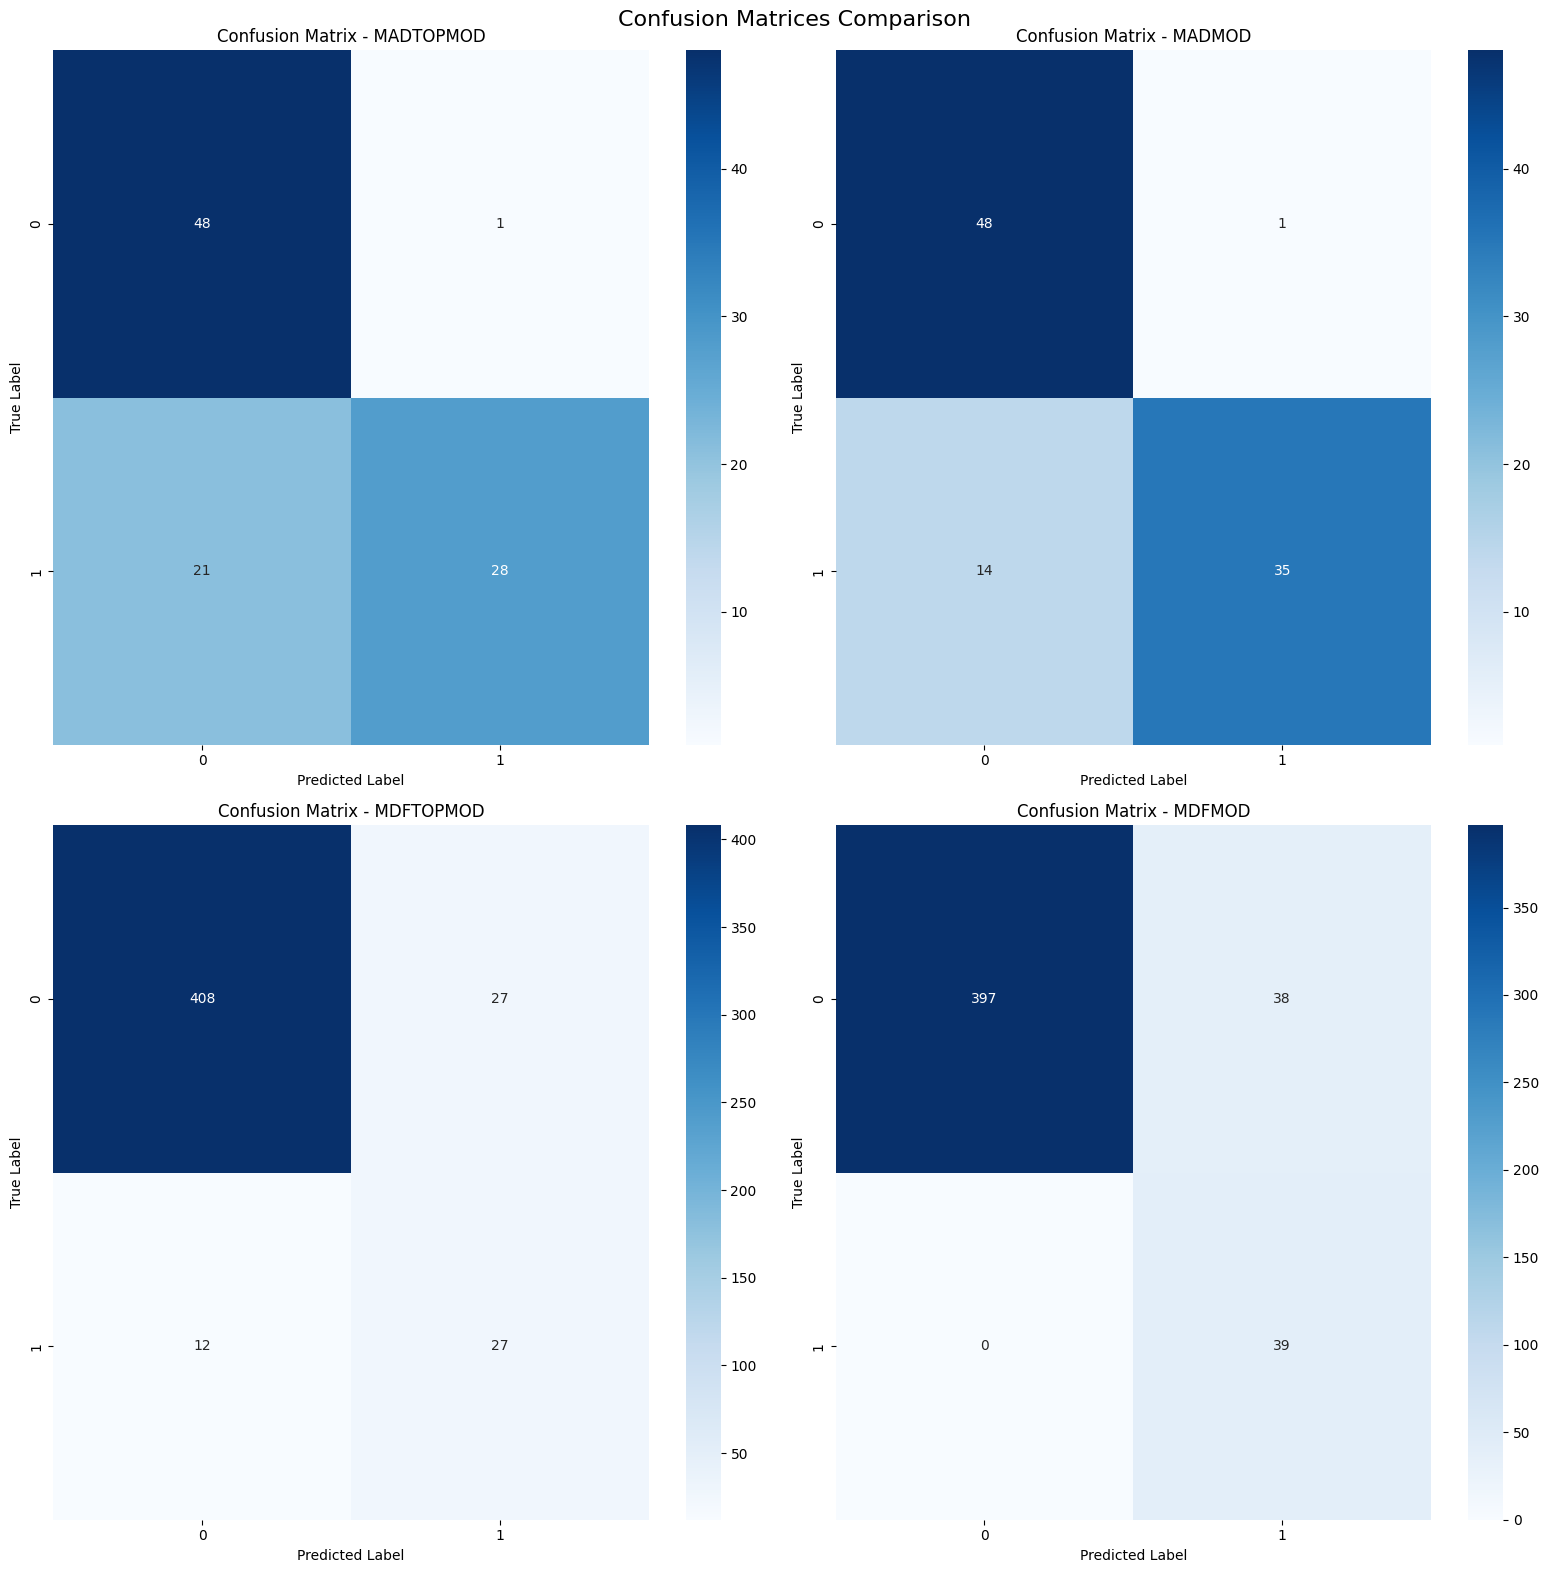

In [52]:
plot_confusion_matrices(cms, summary_df.index)

We will proceed to optimise the MADMOD Model (The adjusted dataframe with all the words) to see if we can improve the results.

In [61]:
# Define the parameter grid
param_grid = {
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto', 0.1, 1]
}


In [62]:
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [63]:
# We create the grid search object
grid_search = GridSearchCV(pipeline_all_words, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1, verbose=1)

In [64]:
# We fit the grid search
print("Starting Grid Search...")
grid_search.fit(X_train_adj, y_train_adj)
print("Grid Search completed.")
print("-"*40)
# We print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

Starting Grid Search...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Grid Search completed.
----------------------------------------
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}
Best F1 score: 0.771719259712702


We will perform a second optimisation to try to fine-tune the model to obtain a better result.

In [66]:
param_grid = {
    'tfidf__max_features': [500, 750, 1000, 1250, 1500],
    'tfidf__ngram_range': [(1, 1), (1, 2)],    
    'svm__C': [5, 8, 10, 12, 15],                     
    'svm__gamma': [0.05, 0.075, 0.1, 0.125 , 0.15]            
}

grid_search = GridSearchCV(pipeline_all_words, param_grid, cv=5, scoring=scoring, refit='f1', n_jobs=-1, verbose=1)


In [67]:
# Fit the grid search
print("Starting Fine-Tuned Grid Search...")
grid_search.fit(X_train_adj, y_train_adj)
print("Fine-Tuned Grid Search completed.")

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)


cv_results = grid_search.cv_results_

best_index = grid_search.best_index_

cv_accuracy = cv_results['mean_test_accuracy'][best_index]

cv_precision = cv_results['mean_test_precision'][best_index]

cv_recall = cv_results['mean_test_recall'][best_index]

cv_f1 = cv_results['mean_test_f1'][best_index]

print("Best Cross-Validation Scores:")
print(f"Accuracy: {cv_accuracy:.4f}")
print(f"Precision: {cv_precision:.4f}")
print(f"Recall: {cv_recall:.4f}")
print(f"F1 Score: {cv_f1:.4f}")

Starting Fine-Tuned Grid Search...
Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Fine-Tuned Grid Search completed.
Best parameters: {'svm__C': 15, 'svm__gamma': 0.15, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}
Best cross-validation F1 score: 0.7613021660004139
Best Cross-Validation Scores:
Accuracy: 0.7590
Precision: 0.7734
Recall: 0.7744
F1 Score: 0.7613


In [68]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_adj)

# Calculate and print metrics
accuracy = accuracy_score(y_test_adj, y_pred)
precision = precision_score(y_test_adj, y_pred)
recall = recall_score(y_test_adj, y_pred)
f1 = f1_score(y_test_adj, y_pred)

print("Optimized MADMOD Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Optimized MADMOD Performance:
Accuracy: 0.8673
Precision: 0.9286
Recall: 0.7959
F1 Score: 0.8571


In [75]:
print("\nComparison with Original MADMOD:")
comparison_df = pd.DataFrame({
    'Original': original_metrics,
    'Optimized': {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }
})
print(comparison_df.to_string(float_format="{:.4f}".format))

# Calculate percentage improvement
improvement = (comparison_df['Optimized'] - comparison_df['Original']) / comparison_df['Original'] * 100
print("\nPercentage Improvement:")
print(improvement.to_string(float_format="{:.2f}%".format))

# Feature importance (if applicable)
if hasattr(best_model['svm'], 'coef_'):
    feature_names = best_model['tfidf'].get_feature_names_out()
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(best_model['svm'].coef_[0])
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))


Comparison with Original MADMOD:
           Original  Optimized
Accuracy     0.8571     0.8673
Precision    0.9730     0.9286
Recall       0.7347     0.7959
F1 Score     0.8372     0.8571

Percentage Improvement:
Accuracy     1.19%
Precision   -4.56%
Recall       8.33%
F1 Score     2.38%


We managed to improve the F1 Score, as well as the Recall, even though we lost a bit of precision, we will finish by displaying the confusion matrix to obtain a visual representation of the results and save the model.

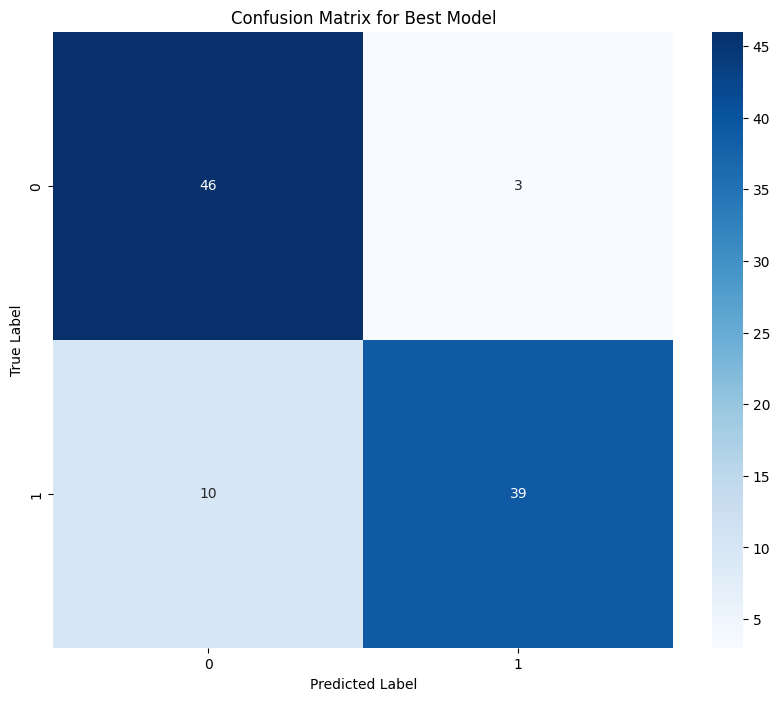

In [76]:
confusion_mat = confusion_matrix(y_test_adj, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [83]:
# Define the model filename and directory
model_filename = 'spam_detector.joblib'
model_dir = r"..\models"

# Ensure the directory exists and save the model
os.makedirs(model_dir, exist_ok=True)
joblib.dump(best_model, os.path.join(model_dir, model_filename))

print(f"Model saved as {model_filename}")

Model saved as spam_detector.joblib
